<a href="https://colab.research.google.com/github/jsansao/idl/blob/main/Licao12bis_CatOrDog_TransferLearningKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lição 12bis - Transfer Learning

Nesta tarefa, vamos comparar diferentes estruturas no reconhecimento de gestos de uma partida de pedra, papel e tesoura.

Utilizaremos redes pré-treinadas com a base imagenet e faremos o aprendizado por transferência. Neste tipo de treinamento, fixamos parte dos coeficientes da rede e adicionamos um novo classificador específico para a tarefa.

Vamos comparar as seguintes redes disponibilizadas pelo TensorFlow/Keras:



1. InceptionV3
2. VGG16
3. Xception
4. DenseNet

Para cada uma, você deverá determinar os melhores valores de acurácia (treinamento e validação), número de parâmetros treináveis e não treináveis (Ver o model.summary())







## Carregamento do banco de imagens

Os conjuntos estão divididos em dois arquivos zipados. O primeiro é o conjunto de treinamento, o segundo é o conjunto de validação.

Em cada arquivo zipado, temos três diretórios, correspondentes a imagens de pedra, papel e tesoura. Com o ImageGenerator, vamos gerar os tensores para serem processados.



In [ ]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2023-10-10 22:42:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.207, 108.177.120.207, 142.250.103.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   105MB/s    in 0.6s    

2023-10-10 22:42:08 (105 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!unzip  /tmp/cats_and_dogs_filtered.zip

Archive:  /tmp/cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.

## 1. InceptionV3

In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3


pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = "imagenet")



for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (2, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator



train_dir = 'cats_and_dogs_filtered/train/'
validation_dir = 'cats_and_dogs_filtered/validation/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

Epoch 1/20
100/100 - 16s - loss: 7.0501 - accuracy: 0.8480 - val_loss: 0.7532 - val_accuracy: 0.9350 - 16s/epoch - 162ms/step
Epoch 2/20
100/100 - 15s - loss: 2.4042 - accuracy: 0.8990 - val_loss: 0.6452 - val_accuracy: 0.9550 - 15s/epoch - 150ms/step
Epoch 3/20
100/100 - 16s - loss: 1.5730 - accuracy: 0.8965 - val_loss: 0.3545 - val_accuracy: 0.9600 - 16s/epoch - 156ms/step
Epoch 4/20
100/100 - 14s - loss: 0.7092 - accuracy: 0.9110 - val_loss: 1.4966 - val_accuracy: 0.8800 - 14s/epoch - 143ms/step
Epoch 5/20
100/100 - 14s - loss: 0.6259 - accuracy: 0.9000 - val_loss: 0.2245 - val_accuracy: 0.9600 - 14s/epoch - 144ms/step
Epoch 6/20
100/100 - 14s - loss: 0.3114 - accuracy: 0.9100 - val_loss: 0.0823 - val_accuracy: 0.9700 - 14s/epoch - 142ms/step
Epoch 7/20
100/100 - 15s - loss: 0.2042 - accuracy: 0.9275 - val_loss: 0.0803 - val_accuracy: 0.9850 - 15s/epoch - 148ms/step
Epoch 8/20
100/100 - 15s - loss: 0.1966 - accuracy: 0.9325 - val_loss: 0.0965 - val_accuracy: 0.9600 - 15s/epoch - 153

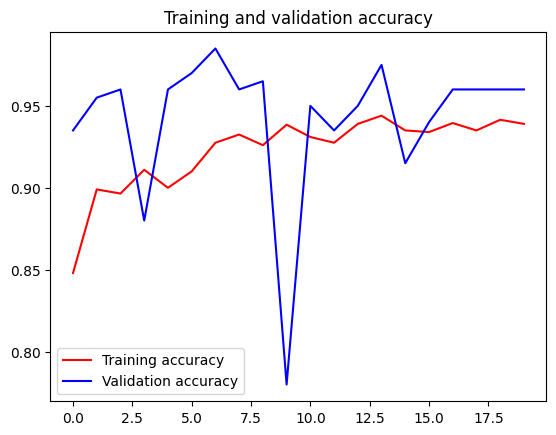

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## 2. VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np



pre_trained_model = VGG16(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (2, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
train_dir = 'cats_and_dogs_filtered/train/'
validation_dir = 'cats_and_dogs_filtered/validation/'


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

Epoch 1/20
100/100 - 18s - loss: 0.6979 - accuracy: 0.6995 - val_loss: 0.3543 - val_accuracy: 0.8450 - 18s/epoch - 183ms/step
Epoch 2/20
100/100 - 15s - loss: 0.4567 - accuracy: 0.7770 - val_loss: 0.3968 - val_accuracy: 0.8400 - 15s/epoch - 151ms/step
Epoch 3/20
100/100 - 17s - loss: 0.4025 - accuracy: 0.8140 - val_loss: 0.2424 - val_accuracy: 0.8850 - 17s/epoch - 172ms/step
Epoch 4/20
100/100 - 16s - loss: 0.3651 - accuracy: 0.8330 - val_loss: 0.2954 - val_accuracy: 0.8550 - 16s/epoch - 162ms/step
Epoch 5/20
100/100 - 15s - loss: 0.3640 - accuracy: 0.8370 - val_loss: 0.3047 - val_accuracy: 0.8800 - 15s/epoch - 149ms/step
Epoch 6/20
100/100 - 15s - loss: 0.3483 - accuracy: 0.8465 - val_loss: 0.3440 - val_accuracy: 0.8650 - 15s/epoch - 154ms/step
Epoch 7/20
100/100 - 16s - loss: 0.3577 - accuracy: 0.8315 - val_loss: 0.2914 - val_accuracy: 0.9050 - 16s/epoch - 158ms/step
Epoch 8/20
100/100 - 15s - loss: 0.3444 - accuracy: 0.8470 - val_loss: 0.3117 - val_accuracy: 0.8750 - 15s/epoch - 148

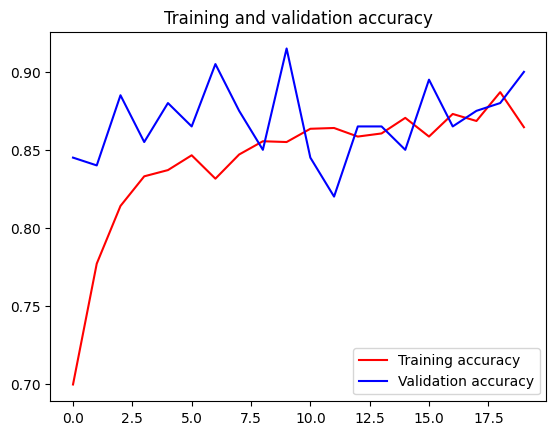

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## 3. Xception

In [ ]:
import tensorflow.keras.applications.xception
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

pre_trained_model = Xception(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')


83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (2, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
train_dir = 'cats_and_dogs_filtered/train/'
validation_dir = 'cats_and_dogs_filtered/validation/'


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

Epoch 1/20
100/100 - 19s - loss: 2.7836 - accuracy: 0.8580 - val_loss: 0.5324 - val_accuracy: 0.9500 - 19s/epoch - 189ms/step
Epoch 2/20
100/100 - 15s - loss: 0.8352 - accuracy: 0.9065 - val_loss: 0.2740 - val_accuracy: 0.9650 - 15s/epoch - 148ms/step
Epoch 3/20
100/100 - 15s - loss: 0.6362 - accuracy: 0.8980 - val_loss: 0.1472 - val_accuracy: 0.9550 - 15s/epoch - 146ms/step
Epoch 4/20
100/100 - 15s - loss: 0.2717 - accuracy: 0.9155 - val_loss: 0.1060 - val_accuracy: 0.9600 - 15s/epoch - 147ms/step
Epoch 5/20
100/100 - 15s - loss: 0.2186 - accuracy: 0.9220 - val_loss: 0.1861 - val_accuracy: 0.9650 - 15s/epoch - 147ms/step
Epoch 6/20
100/100 - 14s - loss: 0.1976 - accuracy: 0.9355 - val_loss: 0.2176 - val_accuracy: 0.9350 - 14s/epoch - 145ms/step
Epoch 7/20
100/100 - 14s - loss: 0.1932 - accuracy: 0.9280 - val_loss: 0.1174 - val_accuracy: 0.9450 - 14s/epoch - 143ms/step
Epoch 8/20
100/100 - 14s - loss: 0.1953 - accuracy: 0.9360 - val_loss: 0.1506 - val_accuracy: 0.9500 - 14s/epoch - 145

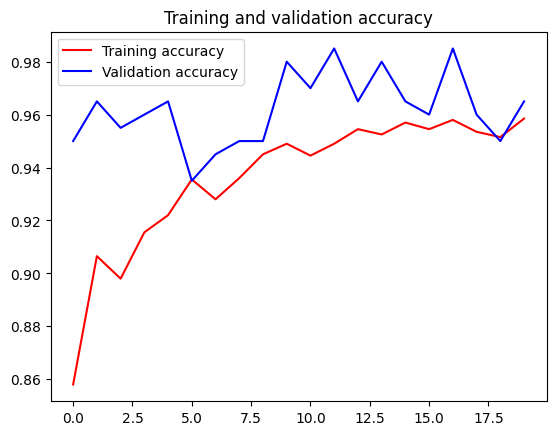

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## 4. DenseNet

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
import numpy as np

pre_trained_model = DenseNet201(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (2, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
train_dir = 'cats_and_dogs_filtered/train/'
validation_dir = 'cats_and_dogs_filtered/validation/'


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

Epoch 1/20
100/100 - 34s - loss: 3.6699 - accuracy: 0.8820 - val_loss: 0.7909 - val_accuracy: 0.9450 - 34s/epoch - 342ms/step
Epoch 2/20
100/100 - 16s - loss: 1.2384 - accuracy: 0.9270 - val_loss: 1.9860 - val_accuracy: 0.9100 - 16s/epoch - 156ms/step
Epoch 3/20
100/100 - 16s - loss: 0.9325 - accuracy: 0.9270 - val_loss: 0.3715 - val_accuracy: 0.9750 - 16s/epoch - 164ms/step
Epoch 4/20
100/100 - 16s - loss: 0.8440 - accuracy: 0.9290 - val_loss: 0.4968 - val_accuracy: 0.9700 - 16s/epoch - 156ms/step
Epoch 5/20
100/100 - 17s - loss: 0.5830 - accuracy: 0.9410 - val_loss: 2.5928 - val_accuracy: 0.8750 - 17s/epoch - 171ms/step
Epoch 6/20
100/100 - 16s - loss: 0.4738 - accuracy: 0.9360 - val_loss: 0.7044 - val_accuracy: 0.9350 - 16s/epoch - 164ms/step
Epoch 7/20
100/100 - 15s - loss: 0.3736 - accuracy: 0.9355 - val_loss: 0.1059 - val_accuracy: 0.9650 - 15s/epoch - 151ms/step
Epoch 8/20
100/100 - 16s - loss: 0.2433 - accuracy: 0.9475 - val_loss: 0.2389 - val_accuracy: 0.9550 - 16s/epoch - 165

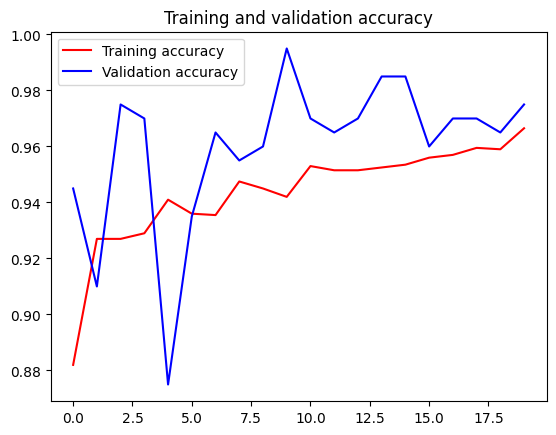

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## 5. EfficientNet

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input #, decode_predictions
import numpy as np

model = EfficientNetB0(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (2, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
train_dir = 'cats_and_dogs_filtered/train/'
validation_dir = 'cats_and_dogs_filtered/validation/'


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

Epoch 1/20
100/100 - 32s - loss: 1.9741 - accuracy: 0.8850 - val_loss: 0.2837 - val_accuracy: 0.9750 - 32s/epoch - 322ms/step
Epoch 2/20
100/100 - 15s - loss: 0.7323 - accuracy: 0.9135 - val_loss: 0.6248 - val_accuracy: 0.9250 - 15s/epoch - 152ms/step
Epoch 3/20
100/100 - 15s - loss: 0.4048 - accuracy: 0.9230 - val_loss: 0.1647 - val_accuracy: 0.9450 - 15s/epoch - 152ms/step
Epoch 4/20
100/100 - 15s - loss: 0.2475 - accuracy: 0.9315 - val_loss: 0.1239 - val_accuracy: 0.9700 - 15s/epoch - 154ms/step
Epoch 5/20
100/100 - 17s - loss: 0.2226 - accuracy: 0.9255 - val_loss: 0.4530 - val_accuracy: 0.9350 - 17s/epoch - 167ms/step
Epoch 6/20
100/100 - 15s - loss: 0.1792 - accuracy: 0.9385 - val_loss: 0.1225 - val_accuracy: 0.9650 - 15s/epoch - 151ms/step
Epoch 7/20
100/100 - 15s - loss: 0.1389 - accuracy: 0.9515 - val_loss: 0.0609 - val_accuracy: 0.9900 - 15s/epoch - 151ms/step
Epoch 8/20
100/100 - 15s - loss: 0.1554 - accuracy: 0.9480 - val_loss: 0.0636 - val_accuracy: 0.9750 - 15s/epoch - 152

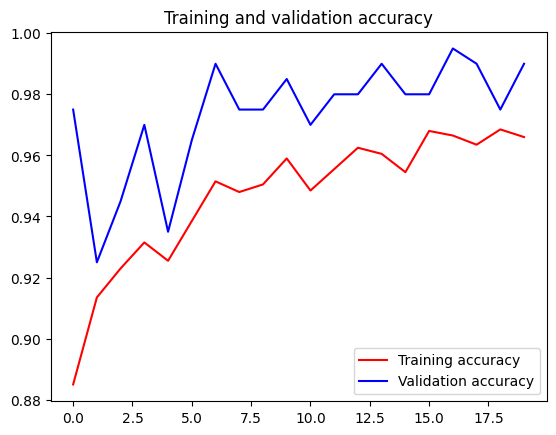

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()